In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import pickle
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [3]:
def readFiles():
    viewLogFile = pd.read_csv('view_log.csv')
    itemDataFile = pd.read_csv('item_data.csv')
    trainFile = pd.read_csv('train.csv')

In [4]:
trainData = trainFile.drop('impression_id', axis = 1)

In [17]:
dayOfMonth = trainData['impression_time'].apply(lambda x: 
                           1 if (1 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day <= 10)
                           else 2 if (11 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day <= 20)
                           else 3)
dayOfWeek = trainData['impression_time'].apply(lambda x: 
                            1 if (1 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").isocalendar()[2] <= 5) else 2)
weekOfYear = trainData['impression_time'].apply(lambda x: 
                            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").isocalendar()[1])
trainData['weekOfYear'] = weekOfYear
trainData['dayOfMonth'] = dayOfMonth
trainData['dayOfWeek'] = dayOfWeek
trainData.drop('impression_time', axis = 1, inplace = True)
trainData = pd.get_dummies(trainData, prefix = ["os"])

In [19]:
def mergeVieLogAndItem():
    viewLogItem = pd.merge(viewLogFile, itemDataFile, on = 'item_id')

In [20]:
def getUserFlattenedOverCategoryData():
    userFlattenedData = viewLogItem.groupby('user_id')['category_1'].value_counts().unstack().fillna(0).reset_index()
    userFlattenedData.columns = [userFlattenedData.columns[0]] + ["Category_1_" + str(x) for x in userFlattenedData.columns[1:]]

In [21]:
userFlattenedData.head()

,user_id,Category_1_0,Category_1_1,Category_1_2,Category_1_4,Category_1_5,Category_1_6,Category_1_7,Category_1_8,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17
0,0,0.0,7.0,0.0,1.0,0.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,1.0,2.0,7.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0
2,2,1.0,31.0,0.0,6.0,0.0,1.0,10.0,9.0,19.0,8.0,11.0,11.0,8.0,11.0,5.0,8.0,26.0
3,3,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [354]:
# def finalPrediction():
viewLogItem = pd.merge(viewLogFile, itemDataFile, on = 'item_id')
userFlattenedData = viewLogItem.groupby('user_id')['category_1'].value_counts().unstack().fillna(0).reset_index()
userFlattenedData.columns = [ 'user_id', 'Category_1_0', 'Category_1_1', 
                           'Category_1_2', 'Category_1_4', 'Category_1_5', 'Category_1_6', 'Category_1_7', 
                           'Category_1_8', 'Category_1_9', 'Category_1_10', 'Category_1_11', 'Category_1_12', 
                           'Category_1_13', 'Category_1_14', 'Category_1_15', 'Category_1_16', 'Category_1_17']
pickle.dump(userFlattenedData, open('userFlattenedDataFullTrainingData.pickle', 'wb'))
dataToTrain = pd.merge(trainData, userFlattenedData, on = 'user_id')
# X_train, X_test, Y_train, Y_test = train_test_split(dataToTrain.drop(['is_click'], axis = 1), 
#                                                     dataToTrain['is_click'], test_size = 0.2)



# underSampled = pd.concat([X_train, Y_train], axis = 1)
underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
         dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
         axis = 0).sample(frac=1)
lr_parameters = {"C" : (0.01, 0.03, 0.007 ), "penalty" : ('l1', 'l2')}
lr_Cat1 = LogisticRegression()
lr_gs_clf = GridSearchCV(lr_Cat1, lr_parameters, cv = 5)
lr_gs_clf.fit(underSampledDataSet[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth','dayOfWeek',
                                   'weekOfYear','os_intermediate','os_latest','os_old']], underSampledDataSet['is_click'])
# lr_gs_clf.fit(underSampledDataSet.drop(['is_click', 'user_id'], axis = 1), underSampledDataSet['is_click'])
print(lr_gs_clf.best_estimator_)
# print(roc_auc_score(Y_test, lr_gs_clf.predict_proba(X_test[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth',
#                                     'dayOfWeek', 'weekOfYear','os_intermediate','os_latest','os_old']])[:,1]))
# print(roc_auc_score(Y_test, lr_gs_clf.predict_proba(X_test.drop(['user_id'], axis = 1))[:,1]))

C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\C

LogisticRegression(C=0.007, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
viewLogItem = pd.merge(viewLogFile, itemDataFile, on = 'item_id')
userFlattenedData = viewLogItem.groupby('user_id')['category_1'].value_counts().unstack().fillna(0).reset_index()
userFlattenedData.columns = [ 'user_id', 'Category_1_0', 'Category_1_1', 
                           'Category_1_2', 'Category_1_4', 'Category_1_5', 'Category_1_6', 'Category_1_7', 
                           'Category_1_8', 'Category_1_9', 'Category_1_10', 'Category_1_11', 'Category_1_12', 
                           'Category_1_13', 'Category_1_14', 'Category_1_15', 'Category_1_16', 'Category_1_17']
pickle.dump(userFlattenedData, open('userFlattenedDataFullTrainingData.pickle', 'wb'))
dataToTrain = pd.merge(trainData, userFlattenedData, on = 'user_id')
X_train, X_test, Y_train, Y_test = train_test_split(dataToTrain.drop(['is_click'], axis = 1), 
                                                    dataToTrain['is_click'], test_size = 0.4)


In [38]:
pickle.dump(userFlattenedData, open('userFlattenedDataFullTrainingData3.pickle', 'wb'))

In [380]:
X_train.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_1_8,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17
51535,78191,386,1,48,3,1,1,0,0,0.0,...,1.0,5.0,3.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0
168558,13159,190,0,48,1,2,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52482,22466,421,0,46,2,2,0,0,1,0.0,...,2.0,1.0,2.0,1.0,1.0,4.0,0.0,1.0,0.0,4.0
155751,30130,421,0,49,1,1,0,1,0,6.0,...,5.0,12.0,14.0,6.0,1.0,22.0,3.0,2.0,4.0,12.0
104711,79074,296,1,47,3,1,0,0,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0


In [30]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_res, Y_res = sm.fit_resample(dataToTrain[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth','dayOfWeek',
                                   'weekOfYear','os_intermediate','os_latest','os_old']], dataToTrain['is_click'])

In [31]:
X_res.shape, Y_res.shape #[Y_res['is_click'] == 1].shape

((453488, 10), (453488,))

In [32]:
# overSampled = pd.concat([X_res, Y_res], axis = 1)
# underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
#          dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
#          axis = 0).sample(frac=1)
# lr_parameters = {"C" : (0.01, 0.03, 0.007 ), "penalty" : ('l1', 'l2')}
# lr_Cat1 = LogisticRegression()
lr_gs_clf = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
# lr_gs_clf = GridSearchCV(lr_Cat1, lr_parameters, cv = 5)
lr_gs_clf.fit(X_res, Y_res)
# lr_gs_clf.fit(underSampledDataSet.drop(['is_click', 'user_id'], axis = 1), underSampledDataSet['is_click'])
# print(lr_gs_clf.best_estimator_)
# print(roc_auc_score(Y_test, lr_gs_clf.predict_proba(X_test[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth',
#                                     'dayOfWeek', 'weekOfYear','os_intermediate','os_latest','os_old']])[:,1]))


C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [202]:
dataToTrain.head()

,user_id,app_code,is_4G,is_click,weekOfYear,os_intermediate,os_latest,os_old,Category_1_0,Category_1_1,...,Category_1_8,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17
0,87862,422,0,0,46,0,0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87862,422,0,0,46,0,0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87862,422,0,0,46,0,0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63410,467,1,1,46,0,1,0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,63410,467,1,0,46,0,1,0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [286]:
underSampledDataSet.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17,is_click
28082,12208,386,1,49,1,1,0,1,0,4.0,...,26.0,19.0,4.0,2.0,6.0,7.0,0.0,8.0,27.0,0
160931,61034,249,0,49,1,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0
50944,14256,190,0,49,1,1,0,0,1,1.0,...,27.0,2.0,13.0,2.0,0.0,1.0,1.0,1.0,7.0,1
230418,37015,207,0,49,1,1,0,1,0,2.0,...,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,0
216138,47332,231,0,49,1,1,0,1,0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [287]:
underSampledDataSetCorr = underSampledDataSet.corr()

In [260]:
underSampledDataSetCorr.head()

,user_id,app_code,is_4G,dayOfMonth,dayOfWeek,weekOfYear,os_intermediate,os_latest,os_old,Category_1_0,...,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17,is_click
user_id,1.000000,-0.018192,0.004205,0.005881,0.001437,-0.000686,-0.003480,-0.005855,0.010568,-0.017198,...,-0.023283,-0.000138,-0.022384,-0.012147,-0.016721,-0.005559,-0.006918,-0.017545,-0.025888,-0.001934
app_code,-0.018192,1.000000,-0.063949,0.004168,-0.012584,-0.005976,0.012810,-0.013603,0.002995,-0.017173,...,-0.001943,-0.007033,-0.001611,-0.009380,-0.004539,0.011472,0.012519,-0.006353,0.007086,-0.002359
is_4G,0.004205,-0.063949,1.000000,0.035313,-0.015106,-0.005098,-0.027542,0.106529,-0.098528,-0.041783,...,-0.062444,-0.053213,-0.045047,-0.044367,-0.060176,-0.058859,-0.051268,-0.042609,-0.072635,-0.014013
dayOfMonth,0.005881,0.004168,0.035313,1.000000,-0.082417,-0.466146,-0.011445,0.001805,0.009657,-0.007121,...,-0.000143,-0.006516,-0.002039,-0.002169,-0.003907,-0.005509,-0.013792,-0.005018,-0.001150,-0.020402
dayOfWeek,0.001437,-0.012584,-0.015106,-0.082417,1.000000,-0.339483,0.003424,0.016027,-0.022631,0.019045,...,0.022873,0.016865,0.021841,0.019633,0.020379,0.010367,0.016102,0.020273,0.020830,0.012051


In [297]:
underSampledDataSetPoly = PolynomialFeatures(interaction_only=True).fit_transform(
    underSampledDataSet[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth','dayOfWeek',
                                   'weekOfYear','os_intermediate','os_latest','os_old']])

In [301]:
underSampledDataSetPolyDf = pd.DataFrame(underSampledDataSetPoly, columns=["Category_11_" + str(x) for x in range(0, underSampledDataSetPoly.shape[1])])

In [302]:
underSampledDataSetPolyDf.head()

,Category_11_0,Category_11_1,Category_11_2,Category_11_3,Category_11_4,Category_11_5,Category_11_6,Category_11_7,Category_11_8,Category_11_9,...,Category_11_46,Category_11_47,Category_11_48,Category_11_49,Category_11_50,Category_11_51,Category_11_52,Category_11_53,Category_11_54,Category_11_55
0,1.0,1.0,0.0,145.0,1.0,2.0,2.0,46.0,0.0,0.0,...,92.0,0.0,0.0,2.0,0.0,0.0,46.0,0.0,0.0,0.0
1,1.0,52.0,0.0,465.0,0.0,2.0,1.0,46.0,0.0,1.0,...,46.0,0.0,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,407.0,0.0,1.0,1.0,49.0,0.0,1.0,...,49.0,0.0,1.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0
3,1.0,6.0,0.0,469.0,0.0,3.0,1.0,48.0,0.0,1.0,...,48.0,0.0,1.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0
4,1.0,5.0,0.0,207.0,1.0,1.0,2.0,48.0,0.0,0.0,...,96.0,0.0,0.0,2.0,0.0,0.0,48.0,0.0,0.0,0.0


In [330]:
underSampledDataSetPolyDf.shape

(17156, 56)

In [331]:
underSampledDataSet.shape

(17156, 27)

In [350]:
underSampledDataSet.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17,is_click
52716,42288,145,1,46,2,2,0,0,1,0.0,...,0.0,1.0,3.0,1.0,1.0,0.0,2.0,0.0,0.0,1
90838,88241,465,0,46,2,1,0,1,0,3.0,...,18.0,5.0,23.0,4.0,6.0,4.0,2.0,1.0,15.0,1
123104,77763,407,0,49,1,1,0,1,0,0.0,...,8.0,1.0,3.0,1.0,1.0,2.0,0.0,1.0,4.0,0
152691,77936,469,0,48,3,1,0,1,0,3.0,...,25.0,6.0,6.0,10.0,22.0,3.0,3.0,5.0,30.0,1
208668,21379,207,1,48,1,2,0,0,1,1.0,...,8.0,6.0,1.0,3.0,2.0,0.0,2.0,1.0,4.0,0


In [321]:
underSampledDataSetPolyDf.head()

,Category_11_0,Category_11_1,Category_11_2,Category_11_3,Category_11_4,Category_11_5,Category_11_6,Category_11_7,Category_11_8,Category_11_9,...,Category_11_46,Category_11_47,Category_11_48,Category_11_49,Category_11_50,Category_11_51,Category_11_52,Category_11_53,Category_11_54,Category_11_55
0,1.0,1.0,0.0,145.0,1.0,2.0,2.0,46.0,0.0,0.0,...,92.0,0.0,0.0,2.0,0.0,0.0,46.0,0.0,0.0,0.0
1,1.0,52.0,0.0,465.0,0.0,2.0,1.0,46.0,0.0,1.0,...,46.0,0.0,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,407.0,0.0,1.0,1.0,49.0,0.0,1.0,...,49.0,0.0,1.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0
3,1.0,6.0,0.0,469.0,0.0,3.0,1.0,48.0,0.0,1.0,...,48.0,0.0,1.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0
4,1.0,5.0,0.0,207.0,1.0,1.0,2.0,48.0,0.0,0.0,...,96.0,0.0,0.0,2.0,0.0,0.0,48.0,0.0,0.0,0.0


In [325]:
pd.concat?

In [344]:
userFlattenedAll = pd.concat([underSampledDataSet.reset_index(drop=True),underSampledDataSetPolyDf.reset_index(drop=True)], axis = 1)

In [345]:
userFlattenedAll.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_11_46,Category_11_47,Category_11_48,Category_11_49,Category_11_50,Category_11_51,Category_11_52,Category_11_53,Category_11_54,Category_11_55
0,42288,145,1,46,2,2,0,0,1,0.0,...,92.0,0.0,0.0,2.0,0.0,0.0,46.0,0.0,0.0,0.0
1,88241,465,0,46,2,1,0,1,0,3.0,...,46.0,0.0,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0
2,77763,407,0,49,1,1,0,1,0,0.0,...,49.0,0.0,1.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0
3,77936,469,0,48,3,1,0,1,0,3.0,...,48.0,0.0,1.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0
4,21379,207,1,48,1,2,0,0,1,1.0,...,96.0,0.0,0.0,2.0,0.0,0.0,48.0,0.0,0.0,0.0


In [346]:
userFlattenedAll.shape

(17156, 83)

In [343]:
underSampledDataSetPoly.shape

(17156, 56)

In [ ]:
underSampledDataSetPoly = PolynomialFeatures(interaction_only=True).fit_transform(
    underSampledDataSet[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth','dayOfWeek',
                                   'weekOfYear','os_intermediate','os_latest','os_old']]))
underSampledDataSetPolyDf = pd.DataFrame(underSampledDataSetPoly, columns=["Category_11_" + str(x) for x in range(0, userFlattenedDataPoly.shape[1])])
# dataToTrainPoly = PolynomialFeatures(interaction_only=True).fit_transform(userFlattenedData)
userFlattenedAll = pd.concat([userFlattenedData,userFlattenedDataPolyDf], axis = 1)
dataToTrain = pd.merge(trainData, userFlattenedAll, on = 'user_id')
underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
     dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
     axis = 0).sample(frac=1)
lrFullTrain = LogisticRegressionCV()
lrFullTrain.fit(underSampledDataSet[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']], underSampledDataSet['is_click'])
return lrFullTrain
    

In [347]:
userFlattenedAll_corr = userFlattenedAll.corr()

In [353]:
userFlattenedAll_corr[userFlattenedAll_corr['is_click'] > 0.05]

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_11_46,Category_11_47,Category_11_48,Category_11_49,Category_11_50,Category_11_51,Category_11_52,Category_11_53,Category_11_54,Category_11_55
Category_1_0,-0.013595,-0.011816,-0.061578,-0.009934,-0.003927,0.009102,0.047367,-0.025297,-0.018939,1.000000,...,0.008346,0.048659,-0.025567,-0.011964,0.047243,-0.025496,-0.019145,NaN,NaN,NaN
Category_1_1,-0.007450,0.002348,-0.072555,-0.014094,-0.002908,-0.000371,0.043609,-0.046121,0.009797,0.671999,...,-0.001485,0.040688,-0.042664,0.010542,0.043428,-0.046352,0.009477,NaN,NaN,NaN
Category_1_4,0.004002,0.004434,-0.069277,-0.004561,-0.002162,0.008407,0.040786,-0.036151,0.000831,0.650202,...,0.007974,0.039653,-0.031615,0.004605,0.040900,-0.036203,0.000526,NaN,NaN,NaN
Category_1_7,-0.009879,-0.007528,-0.057092,-0.011727,-0.009542,0.008431,0.038835,-0.031614,-0.002558,0.603811,...,0.007847,0.036387,-0.025767,0.000701,0.038942,-0.031882,-0.003010,NaN,NaN,NaN
Category_1_8,0.012383,-0.010885,-0.060594,-0.021856,-0.000572,0.002283,0.045934,-0.039584,-0.000412,0.585883,...,0.000701,0.039719,-0.035972,0.005217,0.045692,-0.039878,-0.001045,NaN,NaN,NaN
Category_1_9,-0.012828,-0.005637,-0.077942,-0.021314,-0.001013,-0.001671,0.040760,-0.036965,0.001829,0.666747,...,-0.003224,0.036439,-0.034408,0.003603,0.040700,-0.037413,0.001222,NaN,NaN,NaN
Category_1_10,0.009201,-0.006976,-0.062128,-0.009027,-0.006153,0.007127,0.049303,-0.043461,0.000720,0.597248,...,0.006465,0.049200,-0.038967,0.002793,0.049170,-0.043350,0.000223,NaN,NaN,NaN
Category_1_11,-0.012345,-0.005906,-0.048255,-0.010239,-0.001932,-0.002404,0.038149,-0.022000,-0.013313,0.605793,...,-0.003252,0.036040,-0.025173,-0.008183,0.038238,-0.022119,-0.013850,NaN,NaN,NaN
Category_1_12,-0.000838,-0.013461,-0.050951,-0.009685,-0.004375,0.002429,0.047139,-0.039637,-0.001597,0.537536,...,0.001731,0.045180,-0.038221,0.002406,0.047253,-0.039869,-0.001981,NaN,NaN,NaN
Category_1_13,-0.009683,-0.014004,-0.070679,-0.014788,0.000307,-0.003832,0.044831,-0.033340,-0.006717,0.630962,...,-0.005049,0.041276,-0.033008,-0.004956,0.044602,-0.033484,-0.007145,NaN,NaN,NaN


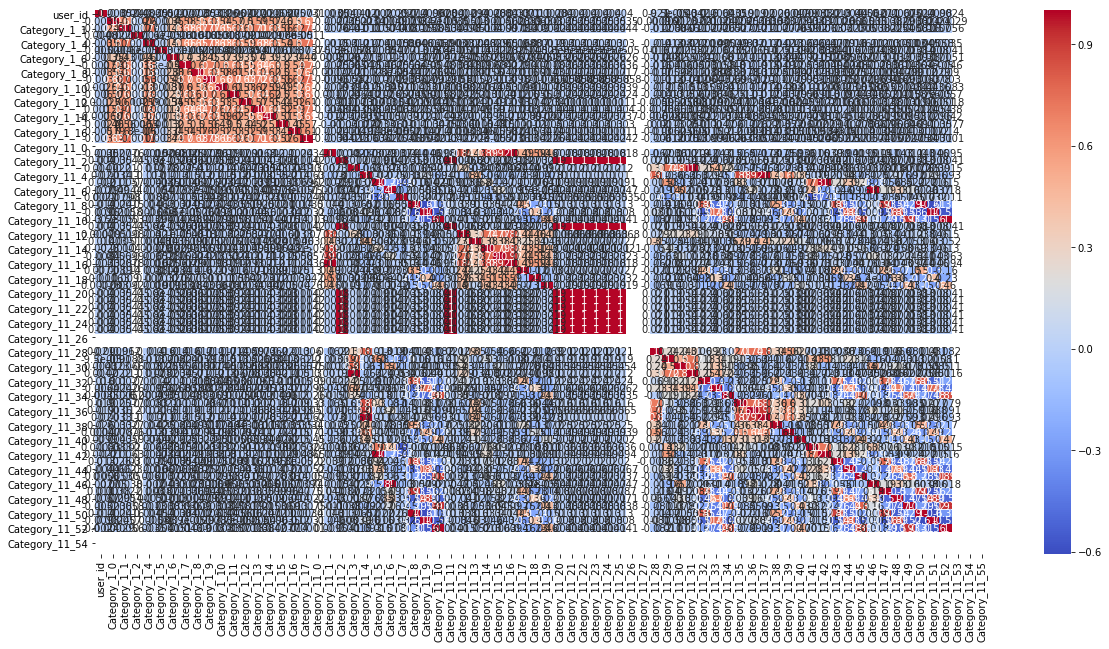

In [307]:
plt.figure(figsize=(20,10))
sns.heatmap(userFlattenedAll.corr(), cmap = 'coolwarm', annot=True)
plt.show()

In [173]:
finalPrediction()

C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\C

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.5464691007060287


In [47]:
def runOnFullTrainingData():
    viewLogItem = pd.merge(viewLogFile, itemDataFile, on = 'item_id')
    userFlattenedData = viewLogItem.groupby('user_id')['category_1'].value_counts().unstack().fillna(0).reset_index()
#     pd.to_pickle()
    userFlattenedData.columns = [ 'user_id', 'Category_1_0', 'Category_1_1', 
                               'Category_1_2', 'Category_1_4', 'Category_1_5', 'Category_1_6', 'Category_1_7', 
                               'Category_1_8', 'Category_1_9', 'Category_1_10', 'Category_1_11', 'Category_1_12', 
                               'Category_1_13', 'Category_1_14', 'Category_1_15', 'Category_1_16', 'Category_1_17']
    pickle.dump(userFlattenedData, open('userFlattenedDataFullTrainingData.pickle', 'wb'))
    dataToTrain = pd.merge(trainData, userFlattenedData, on = 'user_id')
#     X_train, X_test, Y_train, Y_test = train_test_split(dataToTrain.drop(['impression_id', 'impression_time', 'is_click', 
#                                                         'os_version'], axis = 1), dataToTrain['is_click'], test_size = 0.2)
    
    
    
#     underSampled = pd.concat([X_train, Y_train], axis = 1)
    underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
             dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
             axis = 0).sample(frac=1)
    lrFullTrain = LogisticRegressionCV()
    lrFullTrain.fit(underSampledDataSet[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']], underSampledDataSet['is_click'])
    return lrFullTrain
#     print(roc_auc_score(Y_test, lr2.predict_proba(X_test[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']])[:,1]))
#     lr = LogisticRegressionCV()
#     lr.fit(X_train, Y_train)
#     lr.predict_proba(X_test)[:,1]
#     roc_auc_score(Y_test, lr.predict_proba(X_test)[:,1])
    

In [48]:
lrFullTrain = runOnFullTrainingData()

C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [82]:
pd.merge?

In [83]:
# def predictionOnTestData():
testData = pd.read_csv('test.csv')
userFlattenedDataForTest = pickle.load(open('userFlattenedDataFullTrainingData.pickle','rb'))
dataToTest = pd.merge(testData, userFlattenedDataForTest, how='left',on = 'user_id')




In [88]:
dataToTest = dataToTest.fillna(0)

In [356]:
dataToTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90675 entries, 0 to 90674
Data columns (total 23 columns):
impression_id      90675 non-null object
impression_time    90675 non-null object
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
Category_1_0       90675 non-null float64
Category_1_1       90675 non-null float64
Category_1_2       90675 non-null float64
Category_1_4       90675 non-null float64
Category_1_5       90675 non-null float64
Category_1_6       90675 non-null float64
Category_1_7       90675 non-null float64
Category_1_8       90675 non-null float64
Category_1_9       90675 non-null float64
Category_1_10      90675 non-null float64
Category_1_11      90675 non-null float64
Category_1_12      90675 non-null float64
Category_1_13      90675 non-null float64
Category_1_14      90675 non-null float64
Category_1_15      90675 non-null float64
Category_1_16     

In [357]:
userFlattenedDataForTest.shape

(89152, 18)

In [358]:
len(np.unique(userFlattenedDataForTest['user_id']))

89152

In [359]:
len(np.unique(testData['user_id']))

34079

In [360]:
dataToTest.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,Category_1_0,Category_1_1,Category_1_2,Category_1_4,...,Category_1_8,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,1.0,14.0,0.0,2.0,...,3.0,11.0,4.0,6.0,1.0,9.0,5.0,1.0,6.0,7.0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,1.0,8.0,0.0,0.0,...,3.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,2.0,5.0,0.0,2.0,...,2.0,1.0,0.0,5.0,1.0,3.0,1.0,0.0,0.0,3.0


In [ ]:
def writeToOutputFile():
    final_predicted = lrFullTrain.predict(dataToTest[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']])
    outputFile = pd.concat([dataToTest,pd.DataFrame(final_predicted, columns = ['is_click'])], axis = 1)
    outputFile[['impression_id', 'is_click']].to_csv('SubmitPredict.csv',index=False)

In [355]:
# def predictionOnTestData():
testData = pd.read_csv('test.csv')

# pickle.dump(userFlattenedData, open('userFlattenedDataFullTrainingData2.pickle', 'wb'))
userFlattenedDataForTest = pickle.load(open('userFlattenedDataFullTrainingData2.pickle','rb'))
dataToTest = pd.merge(testData, userFlattenedDataForTest, how='left',on = 'user_id')
dataToTest = dataToTest.fillna(0)



In [33]:
testFile = pd.read_csv('test.csv')
testData = testFile.drop('impression_id', axis = 1)
dayOfMonth = testData['impression_time'].apply(lambda x: 
                           1 if (1 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day <= 10)
                           else 2 if (11 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day <= 20)
                           else 3)

dayOfWeek = testData['impression_time'].apply(lambda x: 
                            1 if (1 <= datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").isocalendar()[2] <= 5) else 2)

weekOfYear = testData['impression_time'].apply(lambda x: 
                            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").isocalendar()[1])


dayOfMonth.shape, dayOfWeek.shape, weekOfYear.shape

testData['weekOfYear'] = weekOfYear

testData['dayOfMonth'] = dayOfMonth

testData['dayOfWeek'] = dayOfWeek

testData.drop('impression_time', axis = 1, inplace = True)

testData = pd.get_dummies(testData, prefix = ["os"])

In [34]:
dayOfMonth.shape, dayOfWeek.shape, weekOfYear.shape

((90675,), (90675,), (90675,))

In [35]:
trainData.head()

,user_id,app_code,is_4G,is_click,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old
0,87862,422,0,0,46,2,1,0,0,1
1,63410,467,1,1,46,2,1,0,1,0
2,71748,259,1,0,46,2,1,1,0,0
3,69209,244,1,0,46,2,1,0,1,0
4,62873,473,0,0,46,2,1,0,1,0


In [36]:
testData.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old
0,44754,127,1,50,2,1,0,1,0
1,29656,44,0,50,2,1,0,1,0
2,25234,296,1,50,2,1,0,1,0
3,22988,207,1,50,2,1,0,1,0
4,35431,242,1,50,2,1,0,1,0


In [39]:
userFlattenedDataForTest = pickle.load(open('userFlattenedDataFullTrainingData3.pickle','rb'))
dataToTest = pd.merge(testData, userFlattenedDataForTest, how='left',on = 'user_id')
dataToTest = dataToTest.fillna(0)

In [41]:
underSampledDataSet.head()

NameError: name 'underSampledDataSet' is not defined

In [40]:
dataToTest.head()

,user_id,app_code,is_4G,weekOfYear,dayOfMonth,dayOfWeek,os_intermediate,os_latest,os_old,Category_1_0,...,Category_1_8,Category_1_9,Category_1_10,Category_1_11,Category_1_12,Category_1_13,Category_1_14,Category_1_15,Category_1_16,Category_1_17
0,44754,127,1,50,2,1,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29656,44,0,50,2,1,0,1,0,1.0,...,3.0,11.0,4.0,6.0,1.0,9.0,5.0,1.0,6.0,7.0
2,25234,296,1,50,2,1,0,1,0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
3,22988,207,1,50,2,1,0,1,0,1.0,...,3.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0
4,35431,242,1,50,2,1,0,1,0,2.0,...,2.0,1.0,0.0,5.0,1.0,3.0,1.0,0.0,0.0,3.0


In [42]:
def writeToOutputFileApproach2():
    final_predicted = lr_gs_clf.predict(dataToTest[['Category_1_1', 'Category_1_2', 'app_code','is_4G','dayOfMonth','dayOfWeek',
                                   'weekOfYear','os_intermediate','os_latest','os_old']])
    outputFile = pd.concat([testFile,pd.DataFrame(final_predicted, columns = ['is_click'])], axis = 1)
    outputFile[['impression_id', 'is_click']].to_csv('SubmitPredict2.csv',index=False)
# lr_gs_clf

In [43]:
writeToOutputFileApproach2()

###  Using Polynomial Features

In [104]:


# dataToTrain = pd.merge(trainData, userFlattenedData, on = 'user_id')


In [137]:
dataToTrainCorr = dataToTrain.corr()

In [ ]:
underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
         dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
         axis = 0).sample(frac=1)
lrFullTrain = LogisticRegressionCV()
lrFullTrain.fit(underSampledDataSet[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']], underSampledDataSet['is_click'])
return lrFullTrain

In [141]:
dataToTrainCorr[dataToTrainCorr['is_click'] < -0.1].head()

,user_id,app_code,is_4G,is_click,Category_1_0,Category_1_1,Category_1_2,Category_1_4,Category_1_5,Category_1_6,...,Category_11_144,Category_11_145,Category_11_146,Category_11_147,Category_11_148,Category_11_149,Category_11_150,Category_11_151,Category_11_152,Category_11_153


In [120]:
userFlattenedDataPolyDf.shape

(89152, 172)

In [128]:
pd.concat([userFlattenedData,userFlattenedDataPolyDf], axis = 1)

,user_id,Category_1_0,Category_1_1,Category_1_2,Category_1_4,Category_1_5,Category_1_6,Category_1_7,Category_1_8,Category_1_9,...,Category_1_144,Category_1_145,Category_1_146,Category_1_147,Category_1_148,Category_1_149,Category_1_150,Category_1_151,Category_1_152,Category_1_153
0,0,0.0,7.0,0.0,1.0,0.0,5.0,8.0,0.0,0.0,...,18.0,2.0,4.0,14.0,9.0,18.0,63.0,2.0,7.0,14.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,31.0,0.0,6.0,0.0,1.0,10.0,9.0,19.0,...,88.0,40.0,64.0,208.0,55.0,88.0,286.0,40.0,130.0,208.0
3,3,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,4.0,1.0,0.0,1.0,4.0,0.0,4.0,0.0,1.0,0.0
7,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
8,8,20.0,15.0,0.0,15.0,0.0,2.0,5.0,12.0,24.0,...,152.0,247.0,19.0,551.0,104.0,8.0,232.0,13.0,377.0,29.0
9,9,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,4.0,8.0,12.0,0.0,0.0,0.0,2.0,3.0,6.0


In [126]:
userFlattenedDataPolyDf = pd.DataFrame(userFlattenedDataPoly, columns=["Category_1_" + str(x) for x in range(0, userFlattenedDataPoly.shape[1])])

In [118]:
dataToTrain = pd.merge(trainData, userFlattenedDataPolyDf, on = 'user_id')

KeyError: 'user_id'

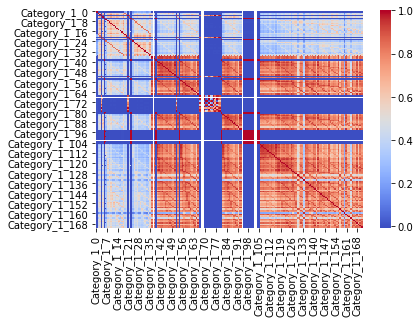

In [117]:
# plt.figure(figsize=(10,8))
sns.heatmap(userFlattenedDataPolyDf.corr(), cmap = 'coolwarm')
# plt.show()

In [149]:
# from sklearn.preprocessing import PolynomialFeatures
# def finalPrediction():
#     viewLogItem = pd.merge(viewLogFile, itemDataFile, on = 'item_id')
#     userFlattenedData = viewLogItem.groupby('user_id')['category_1'].value_counts().unstack().fillna(0).reset_index()
#     userFlattenedData.columns = [ 'user_id', 'Category_1_0', 'Category_1_1', 
#                                'Category_1_2', 'Category_1_4', 'Category_1_5', 'Category_1_6', 'Category_1_7', 
#                                'Category_1_8', 'Category_1_9', 'Category_1_10', 'Category_1_11', 'Category_1_12', 
#                                'Category_1_13', 'Category_1_14', 'Category_1_15', 'Category_1_16', 'Category_1_17']
#     dataToTrain = pd.merge(trainData, userFlattenedData, on = 'user_id')
    
#     dataToTrainPoly = PolynomialFeatures(interaction_only=True).fit_transform
# X_train, X_test, Y_train, Y_test = train_test_split(dataToTrain.drop(['impression_id', 'impression_time', 'is_click', 
#                                                     'os_version'], axis = 1), dataToTrain['is_click'], test_size = 0.2)



underSampled = pd.concat([X_train, Y_train], axis = 1)
underSampledDataSet = pd.concat([underSampled[underSampled['is_click'] == 1], 
         underSampled[underSampled['is_click'] == 0].sample(n = underSampled[underSampled['is_click'] == 1].shape[0])], 
         axis = 0).sample(frac=1)
# lr2 = LogisticRegressionCV()
lr2.fit(underSampledDataSet.drop('is_click', axis = 1), underSampledDataSet['is_click'])
print(roc_auc_score(Y_test, lr2.predict_proba(X_test)[:,1]))
#     lr = LogisticRegressionCV()
#     lr.fit(X_train, Y_train)
#     lr.predict_proba(X_test)[:,1]
#     roc_auc_score(Y_test, lr.predict_proba(X_test)[:,1])
    

C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Us

0.5709386385246367


C:\Users\sarthak.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
def runOnTrainingDataPoly():
    readFiles()
    getUserFlattenedOverCategoryData()
    
    userFlattenedDataPoly = PolynomialFeatures(interaction_only=True).fit_transform(userFlattenedData.drop(['user_id'], axis = 1))
    userFlattenedDataPolyDf = pd.DataFrame(userFlattenedDataPoly, columns=["Category_11_" + str(x) for x in range(0, userFlattenedDataPoly.shape[1])])
    dataToTrainPoly = PolynomialFeatures(interaction_only=True).fit_transform(userFlattenedData)
    userFlattenedAll = pd.concat([userFlattenedData,userFlattenedDataPolyDf], axis = 1)
    dataToTrain = pd.merge(trainData, userFlattenedAll, on = 'user_id')
    underSampledDataSet = pd.concat([dataToTrain[dataToTrain['is_click'] == 1], 
         dataToTrain[dataToTrain['is_click'] == 0].sample(n = dataToTrain[dataToTrain['is_click'] == 1].shape[0])], 
         axis = 0).sample(frac=1)
    lrFullTrain = LogisticRegressionCV()
    lrFullTrain.fit(underSampledDataSet[['Category_1_0', 'Category_1_2', 'app_code', 'is_4G']], underSampledDataSet['is_click'])
    return lrFullTrain
    